# Import needed packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-talk')
plt.rcParams.update({'figure.dpi': 120,'figure.figsize': (6,4)})

from pyQME.spectral_density import SpectralDensity
from pyQME.pump_probe import PumpProbeSpectraCalculator
from pyQME.tensors import RedfieldTensorComplex
from pyQME.tensors_double import RedfieldTensorComplexDouble
from pyQME.utils import overdamped_brownian,underdamped_brownian,get_timeaxis,wn2ips

# Define the system

**Hamiltonian (1/cm)**

In [2]:
nchrom = 3 #number of chromophores

E0 = 10000
energy_gap = 100
coupling_12 = 100
coupling_23 = 30
coupling_13 = 10
H = np.zeros((nchrom,nchrom)) #hamiltonian

H[0] = np.asarray([E0          , coupling_12     , coupling_13     ])
H[1] = np.asarray([coupling_12 , E0+energy_gap   , coupling_23     ])
H[2] = np.asarray([coupling_13 , coupling_23     , E0+2*energy_gap ])

In [3]:
H

array([[1.00e+04, 1.00e+02, 1.00e+01],
       [1.00e+02, 1.01e+04, 3.00e+01],
       [1.00e+01, 3.00e+01, 1.02e+04]])

**Transition dipoles (Debye)**

In [4]:
dipoles = np.ones([nchrom,3])

**Temperature (Kelvin)**

In [5]:
temp = 298

**Spectral density**

In [6]:
freq_axis_SD = np.arange(0.1,4000,0.1)

In [7]:
SD_data = overdamped_brownian(freq_axis_SD,30,37)
SD_data = SD_data + underdamped_brownian(freq_axis_SD,5,50,1000)

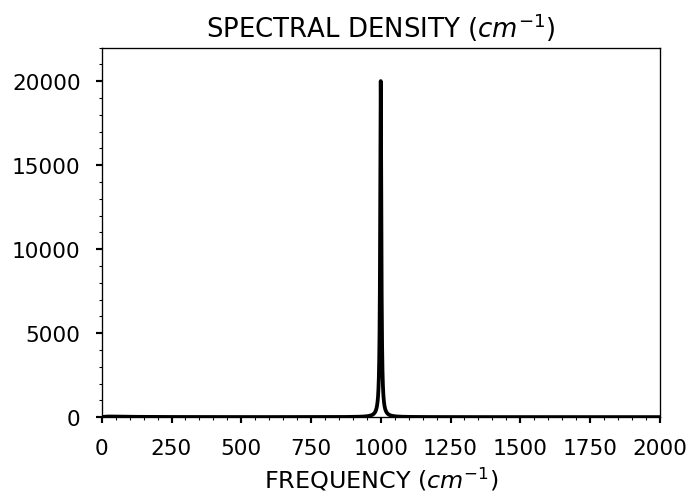

In [8]:
plt.plot(freq_axis_SD,SD_data,color='black');
plt.xlim(0,2000);
plt.ylim(0,22000)
plt.title('SPECTRAL DENSITY ($cm^{-1}$)');
plt.xlabel('FREQUENCY ($cm^{-1}$)');
plt.minorticks_on()

In [9]:
SD_obj = SpectralDensity(freq_axis_SD,SD_data,temperature=temp)

**Time axis (cm)**

In [10]:
energies = np.diag(H)
time_axis = get_timeaxis(SD_obj.Reorg,energies,5)
SD_obj.time = time_axis

**Relaxation Tensors**

In [11]:
rel_tens_obj = RedfieldTensorComplex(H,SD_obj)
rel_tens_obj_double = RedfieldTensorComplexDouble(H,SD_obj)

# Excited State Dynamics

**Load from file**

In [12]:
data = np.loadtxt('excited_state_dynamics/excited_state_dynamics.dat')
time_axis_ps = data[:,0]     #to be saved
rho_t_site_ = data[:,1:]
rho_t_site = rho_t_site_.reshape((time_axis_ps.size,nchrom,nchrom))

**Convert to exciton basis**

In [13]:
rho_t_exc = rel_tens_obj.transform(rho_t_site)

**Extract the population**

In [14]:
pop_t_exc = np.einsum('tkk->tk',rho_t_exc)

# Spectra calculation

In [15]:
spectrum_obj = PumpProbeSpectraCalculator(rel_tens_obj,rel_tens_obj_double,include_dephasing=False)

In [16]:
spectrum_obj.calc_components_lineshape(dipoles=dipoles)
freq_axis,GSB,SE,ESA,PP = spectrum_obj.get_pump_probe(pop_t_exc)     #to be saved

# Check the results

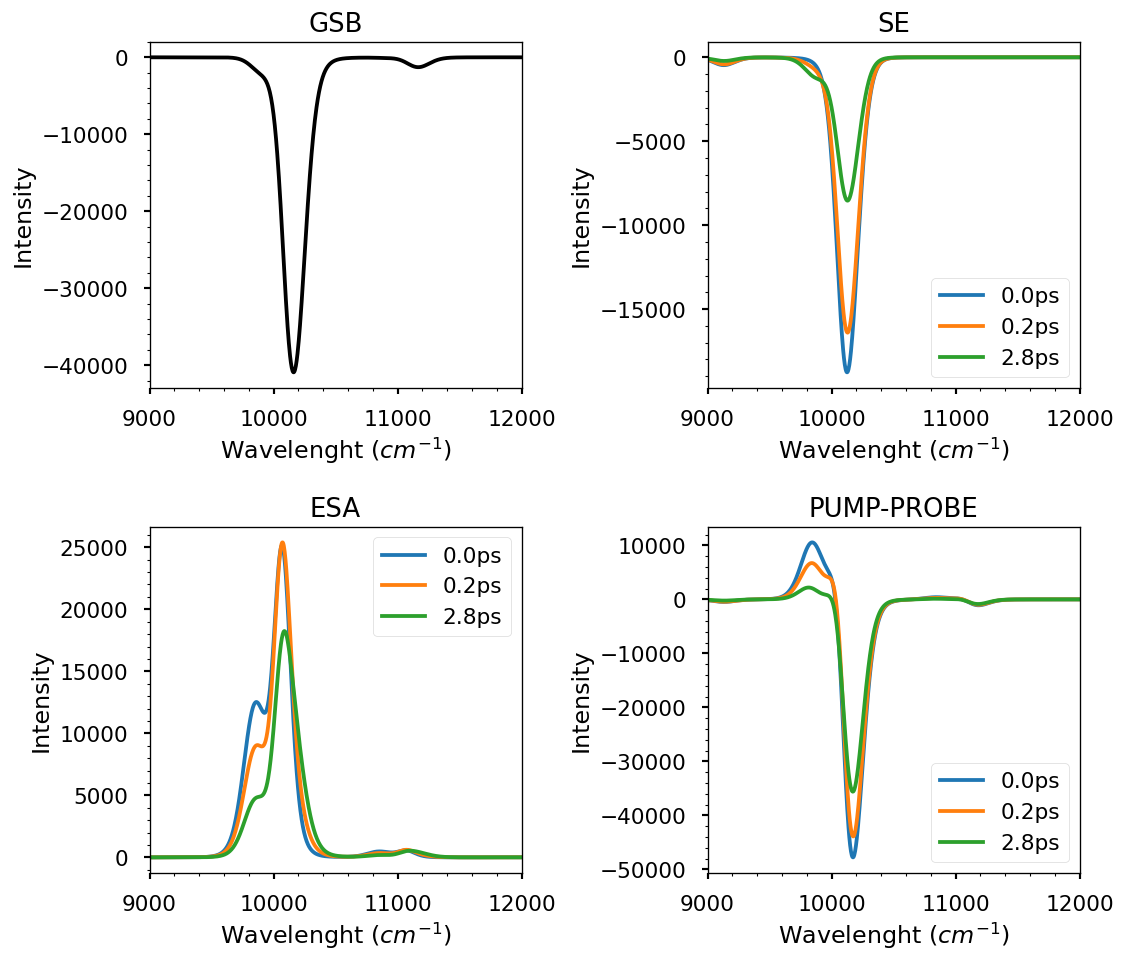

In [17]:
fig, axs = plt.subplots(2,2,gridspec_kw={'wspace': 0.5, 'hspace': 0.4})
fig.set_size_inches(10,9)

#GSB
axs[0,0].plot(freq_axis,GSB,color= 'black')
axs[0,0].set_title('GSB')

for time_idx,time in enumerate(time_axis_ps):
    
    time_string = str(time)+'ps'
    
    #SE
    axs[0,1].plot(freq_axis,SE[time_idx],label = time_string)
    axs[0,1].set_title('SE')

    #ESA
    axs[1,0].plot(freq_axis,ESA[time_idx],label = time_string)
    axs[1,0].set_title('ESA')

    #FULL
    axs[1,1].set_title('PUMP-PROBE')
    axs[1,1].plot(freq_axis,PP[time_idx],label = time_string)

for ax1 in axs:
    for ax2 in ax1:
        ax2.set_xlim(9000,12000)
        ax2.minorticks_on()
        ax2.set_xlabel("Wavelenght ($cm^{-1}$)")
        ax2.set_ylabel("Intensity")
        if not ax2 == axs[0,0]:
            ax2.legend()